In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load general datasets

In [3]:
dataset_test = np.load('../coherent_euclid_dataset/test_Euclid_res_id_001.npy', allow_pickle=True)[()]
dataset_train_2000 = np.load('../coherent_euclid_dataset/train_Euclid_res_2000_TrainStars_id_001.npy', allow_pickle=True)[()]
dataset_train_200 = np.load('../coherent_euclid_dataset/train_Euclid_res_200_TrainStars_id_001.npy', allow_pickle=True)[()]

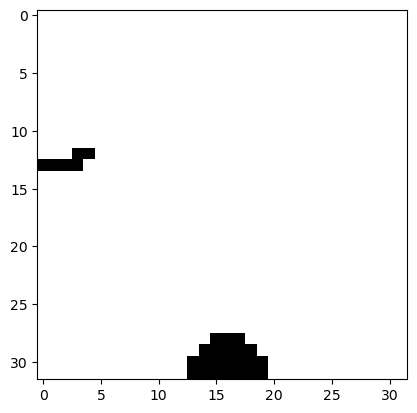

In [4]:
def mask_generator(n, shape):

    def mask_generator_single(shape):
        # 2D meshgrid between 0.5 and 1
        x, y = np.meshgrid(np.linspace(.7, 1.2, shape[1]), np.linspace(.6, 1.1, shape[0]))
        # random pair of 2D frequencies, xy shifts and flip flag
        fxy_list = [np.random.random(5)*6 for _ in range(100)]
        # 2D cosine waves
        cosine_wave_list = [np.cos(2 * np.pi * (fxy[0]*(x-fxy[2]/50) + fxy[1]*(y-fxy[3]/50))) for fxy in fxy_list]
        # Sum of all cosine waves with random orientation
        cosine_wave_tot = np.zeros_like(cosine_wave_list[0])
        for cosine_wave, fxy in zip(cosine_wave_list, fxy_list):
            if fxy[4] < 3:
                cosine_wave = np.flipud(cosine_wave)
            cosine_wave_tot += cosine_wave
        # normalize
        cosine_wave = cosine_wave_tot / np.max(cosine_wave_tot)

        # detect values less than 0.6
        return cosine_wave < 0.6
    
    return np.array([mask_generator_single(shape) for _ in range(n)])
        
plt.imshow(mask_generator(1,(32,32))[0], cmap='gray', vmin=0, vmax=1)
plt.show()

2400
(2400, 32, 32)


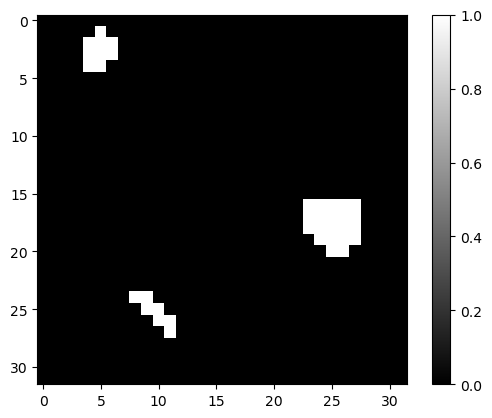

In [7]:
# Generating masks for SFE stars
num_of_stars = len(dataset_train_2000['stars']) + len(dataset_test['stars'])
print(num_of_stars)

shape = dataset_train_2000['stars'][0].shape

masks = mask_generator(num_of_stars, shape)
print(masks.shape)

plt.imshow((1-masks[0]), cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [8]:
dataset_train_2000.keys()

dict_keys(['stars', 'noisy_stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters'])

1073


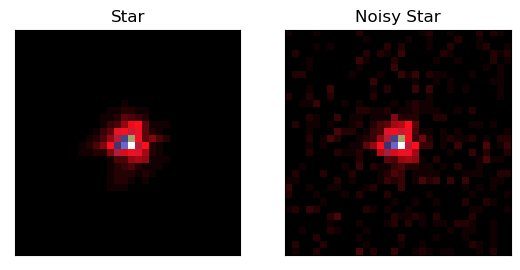

In [9]:
idx = np.random.randint(0, 2001)
print(idx)
# Add masks to the dataset
plt.subplot(1, 2, 1)
plt.imshow(dataset_train_2000['stars'][idx], vmin=0, cmap='gist_stern')
plt.title('Star')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(dataset_train_2000['noisy_stars'][idx], vmin=0, cmap='gist_stern')
plt.title('Noisy Star')
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
dataset_train_2000['masks'] = 1-masks[:2000]
np.save('../masked_dataset/train_Euclid_res_2000_TrainStars_she_masked_id_001.npy', dataset_train_2000, allow_pickle=True )

dataset_train_200['masks'] = 1-masks[:200]
np.save('../masked_dataset/train_Euclid_res_200_TrainStars_she_masked_id_001.npy', dataset_train_200, allow_pickle=True)

In [42]:
dataset_test.keys()

dict_keys(['stars', 'positions', 'SEDs', 'zernike_coef', 'C_poly', 'parameters'])

In [48]:
masked_test_stars = np.array([star*masks[2000+idx] for idx, star in enumerate(dataset_test['stars'])])

In [11]:
len(masks[-400:])

400

In [12]:
dataset_test['masks'] = (1-masks[2000:])

np.save('../masked_dataset/test_Euclid_res_she_masked_id_001.npy', dataset_test, allow_pickle=True)

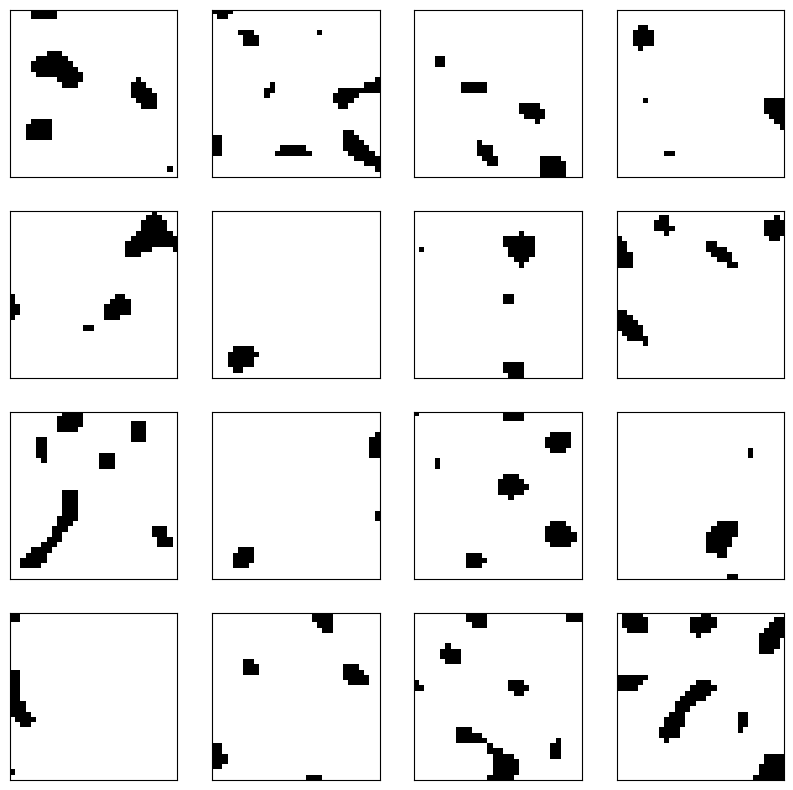

In [13]:
# Plot a bunch of masks
plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.randint(0, 2400, 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(masks[idx], cmap='gray')
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.show()